In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install gensim

In [4]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 4.5 MB/s eta 0:00:00


In [6]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# --- 1. SETUP AND PREPARATION ---
# Download necessary NLTK data (only needs to be done once)
nltk.download('stopwords')
nltk.download('wordnet')

# Load the dataset
try:
    df = pd.read_csv('/content/drive/MyDrive/archive (1)/Tweets.csv') # The file from Kaggle is named Tweets.csv
except FileNotFoundError:
    print("Error: 'Tweets.csv' not found. Please download it from Kaggle and place it in the same folder as the script.")
    exit()

# Initialize tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# --- 2. TEXT PREPROCESSING FUNCTION ---
def preprocess_text(text):
    # Remove @mentions, #hashtags, URLs, and special characters
    text = re.sub(r'[@#][A-Za-z0-9_]+|https?://\S+|[^A-Za-z\s]', '', text)
    # Convert to lowercase and tokenize
    tokens = text.lower().split()
    # Remove stopwords and lemmatize
    processed_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2]
    return processed_tokens

print("Preprocessing text data...")
# Apply the function to the 'text' column
df['processed_text'] = df['text'].apply(preprocess_text)

# --- 3. TOPIC MODELING (ON ALL DATA COMBINED) ---
# This is the key step your supervisor mentioned
print("Training a single topic model on all data...")
all_processed_reviews = df['processed_text'].tolist()

# Create a dictionary and corpus for LDA
dictionary = Dictionary(all_processed_reviews)
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
corpus = [dictionary.doc2bow(text) for text in all_processed_reviews]

# Train the LDA model to find 5 main topics
NUM_TOPICS = 5
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=NUM_TOPICS, random_state=42, passes=10)

print("\nDiscovered Topics (Keywords):")
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic {idx}: {topic}")

# Assign a dominant topic to each review
def get_dominant_topic(doc):
    bow = dictionary.doc2bow(doc)
    topics = lda_model.get_document_topics(bow)
    # Get the topic with the highest probability
    dominant_topic = sorted(topics, key=lambda x: x[1], reverse=True)[0][0]
    return dominant_topic

df['dominant_topic'] = df['processed_text'].apply(get_dominant_topic)

# --- 4. SENTIMENT ANALYSIS ---
print("\nPerforming sentiment analysis on all reviews...")
analyzer = SentimentIntensityAnalyzer()

# Get the compound sentiment score for each original tweet
df['sentiment_score'] = df['text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

# --- 5. FINAL COMBINED ANALYSIS ---
# Group by airline and topic, then calculate the average sentiment
print("\nCalculating average sentiment per topic for each airline...")
final_analysis = df.groupby(['airline', 'dominant_topic'])['sentiment_score'].mean().unstack()

# Rename the topic columns for clarity
# You should manually interpret and name the topics based on their keywords from step 3
# For example, if Topic 0 is about delays, Topic 1 is about customer service, etc.# Find this line in your code and update it:
topic_names = {
    0: "Airport Logistics & Baggage",
    1: "Customer Service Experience",
    2: "Flight Disruptions",
    3: "Booking & Phone Support",
    4: "In-Flight Experience"
}
final_analysis = final_analysis.rename(columns=topic_names)

print("\n--- FINAL RESULTS: Average Sentiment by Topic per Airline ---")
print("Scores range from -1 (Negative) to +1 (Positive). NaN means no reviews for that topic.\n")
# Print the final result table, formatted for better readability
print(final_analysis.to_string(float_format="%.3f"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Preprocessing text data...
Training a single topic model on all data...

Discovered Topics (Keywords):
Topic 0: 0.036*"bag" + 0.016*"plane" + 0.016*"know" + 0.016*"gate" + 0.015*"make" + 0.014*"dont" + 0.014*"work" + 0.013*"right" + 0.012*"thanks" + 0.011*"sure"
Topic 1: 0.062*"service" + 0.060*"customer" + 0.031*"airline" + 0.031*"thanks" + 0.016*"ever" + 0.014*"worst" + 0.012*"never" + 0.012*"experience" + 0.011*"response" + 0.011*"thank"
Topic 2: 0.129*"flight" + 0.044*"cancelled" + 0.042*"hour" + 0.025*"get" + 0.022*"hold" + 0.022*"flightled" + 0.016*"delayed" + 0.015*"late" + 0.015*"tomorrow" + 0.014*"waiting"
Topic 3: 0.039*"call" + 0.030*"help" + 0.026*"get" + 0.025*"cant" + 0.024*"please" + 0.022*"phone" + 0.017*"need" + 0.014*"back" + 0.014*"number" + 0.013*"reservation"
Topic 4: 0.047*"flight" + 0.029*"seat" + 0.020*"time" + 0.020*"thank" + 0.017*"problem" + 0.016*"first" + 0.012*"next" + 0.011*"guy" + 0.010*"boarding" + 0.010*"great"

Performing sentiment analysis on all rev

/tmp/ipython-input-2435534379.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=flight_disruptions.index, y=flight_disruptions.values, palette=colors)
/tmp/ipython-input-2435534379.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=customer_service.index, y=customer_service.values, palette=colors)


Charts have been created and saved as 'airline_sentiment_charts.png'


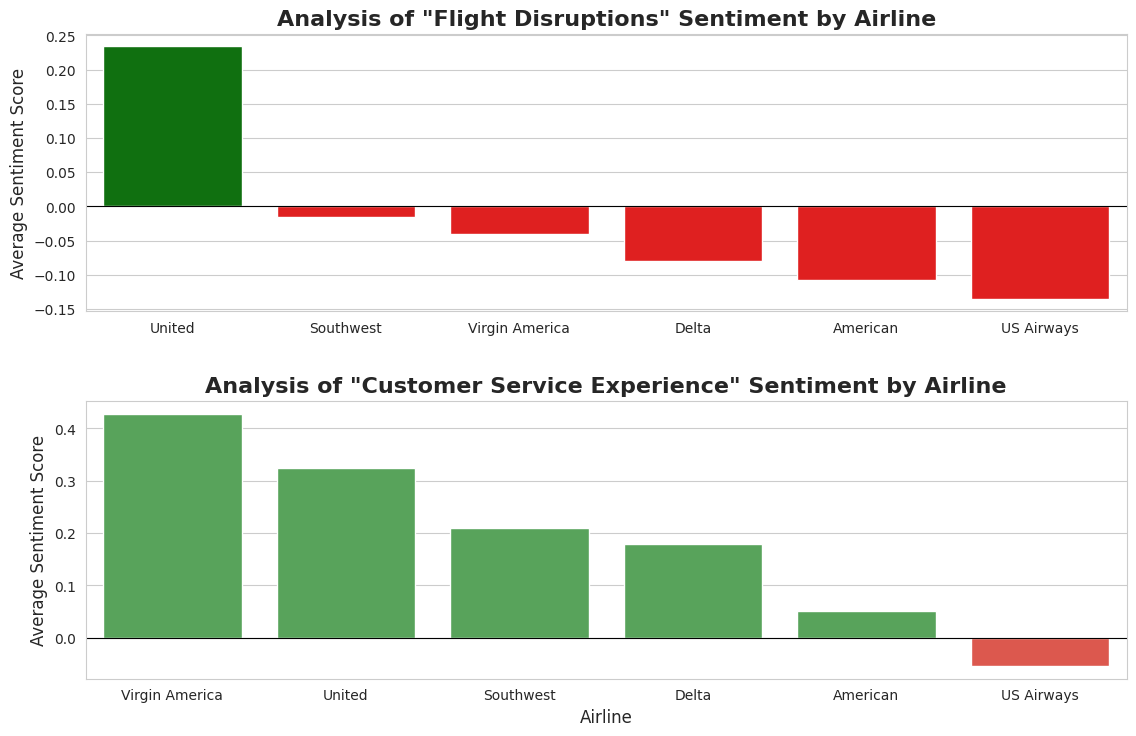

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. RECREATE THE FINAL DATA ---
# This is the final data table from your analysis.
data = {
    'airline': ['American', 'Delta', 'Southwest', 'US Airways', 'United', 'Virgin America'],
    'Airport Logistics & Baggage': [0.107, 0.187, 0.212, 0.044, 0.385, 0.168],
    'Customer Service Experience': [0.051, 0.180, 0.209, -0.054, 0.324, 0.428],
    'Flight Disruptions': [-0.107, -0.080, -0.016, -0.135, 0.234, -0.040],
    'Booking & Phone Support': [0.044, 0.119, 0.142, 0.020, 0.395, 0.018],
    'In-Flight Experience': [0.100, 0.259, 0.229, 0.083, 0.409, 0.243]
}
df_analysis = pd.DataFrame(data).set_index('airline')

# --- 2. VISUALIZATION ---

# Set a professional style for the plots
sns.set_style("whitegrid")
plt.figure(figsize=(12, 8))

# --- Chart 1: Sentiment on Flight Disruptions ---
plt.subplot(2, 1, 1) # Create the first plot in a 2x1 grid
flight_disruptions = df_analysis['Flight Disruptions'].sort_values(ascending=False)

# Create a color palette where positive is green and negative is red
colors = ['green' if x > 0 else 'red' for x in flight_disruptions.values]

sns.barplot(x=flight_disruptions.index, y=flight_disruptions.values, palette=colors)
plt.title('Analysis of "Flight Disruptions" Sentiment by Airline', fontsize=16, fontweight='bold')
plt.ylabel('Average Sentiment Score', fontsize=12)
plt.xlabel('') # No need for x-label as airline names are clear
plt.axhline(0, color='black', linewidth=0.8) # Add a line at zero for reference

# --- Chart 2: Sentiment on Customer Service Experience ---
plt.subplot(2, 1, 2) # Create the second plot
customer_service = df_analysis['Customer Service Experience'].sort_values(ascending=False)
colors = ['#4CAF50' if x > 0 else '#F44336' for x in customer_service.values] # Green/Red colors

sns.barplot(x=customer_service.index, y=customer_service.values, palette=colors)
plt.title('Analysis of "Customer Service Experience" Sentiment by Airline', fontsize=16, fontweight='bold')
plt.ylabel('Average Sentiment Score', fontsize=12)
plt.xlabel('Airline', fontsize=12)
plt.axhline(0, color='black', linewidth=0.8)

# Adjust layout to prevent titles and labels from overlapping
plt.tight_layout(pad=3.0)

# Save the final image to a file
plt.savefig('airline_sentiment_charts.png')

print("Charts have been created and saved as 'airline_sentiment_charts.png'")